# Algoritmos de Clasificación 4 morfologías Elípticas, Espirales e Irregulares. Aumento píxeles y BatchNormalization

## Declaración de Librerías

In [1]:
# mlp for the two circles problem with batchnorm before activation function
import keras
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.metrics import categorical_crossentropy
from keras.layers.convolutional import *
from matplotlib import pyplot
from zipfile import ZipFile
import os
import numpy as np
import io
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
from PIL import Image
import time
import shutil
from google.colab import files
import glob
import cv2 as cv
from google.colab.patches import cv2_imshow
from os import walk
from keras.models import Model
import datetime
from keras.callbacks import ModelCheckpoint

## Upload de las imágenes y preparación de los directorios

In [2]:
# Subimos las imágenes con las que prepararemos nuestro dataset
uploaded = files.upload()

Saving NGCClass4BNOB.zip to NGCClass4BNOB.zip


In [3]:
# Creación del directorio donde descomprimiremos nuestro dataset
!mkdir /content/datangc/

In [4]:
# Extraemos las imágenes del fichero que hemos subido
#with ZipFile('NGCClassification.zip', 'r') as zipObj:
# Dataset para Clasificación de Galaxias según S,E,I
with ZipFile('NGCClass4BNOB.zip', 'r') as zipObj:
#with ZipFile('NGCIAC149.zip', 'r') as zipObj:
#with ZipFile('NGC_1.zip', 'r') as zipObj:
   zipObj.extractall('datangc')

In [5]:
# Verificamos que se haya descomprimido correctamente
os.listdir('/content/datangc/Train')

['E', 'I', 'SNOBAR', 'SBAR']

## Lectura y Visualización de imágenes

In [ ]:
# Procedemos a la lectura de las imágenes y su nombre de fichero para añadirlo 
# a dos listas, lo usaremos por si queremos verificar y ver las imágenes
path = glob.glob("/content/datangc/Train/S/*.jpg")
cv_img = []
name_file = []
for img in path:
    name_file.append(img)
    n = cv.imread(img)
    cv_img.append(n)

In [ ]:
# Verificamos las dimensiones de las imágenes
cv_img[0].shape

(160, 160, 3)

In [ ]:
# Creamos las variables necesarias para posteriormente poder graficas las 
# imágenes extraídas
Tot = len(cv_img)
Cols = 6
Rows = Tot // Cols 
Rows += Tot % Cols
Position = range(1,Tot + 1)

labels=[]
for numimages in range(len(cv_img)):
  namefile = name_file[numimages]
  labels.append(namefile[14:len(namefile)-4])
  labels.append(name_file[numimages])
labels
classes = len(labels)
labels

In [ ]:
# Sacamos por pantalla las imágenes que hemos leído
plt.figure(figsize=(50, 80))
#plt.xticks([]),plt.yticks([])
fig = plt.figure(1)

for k in range(Tot):
  ax = fig.add_subplot(Rows,Cols,Position[k])
  ax.imshow(cv_img[k])      
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Preparamos los Algoritmos de entrenamiento dependiendo el caso de estudio - Redes Neuronales Convolucionales (CNN)


1.   Dataset de Clasificación con 3 Clases Elípticas, Espirales e Irregulares
2.   Dataset de Clasificación con 8 Clases 'E','I','S0a','Sab', 'Sb', 'Sbc', 'Scd', 'Sdm'
3.   Dataset con tantas clases como imágenes de Galaxias 
4. Dataset preparado para realizar Redes Siamesas



In [6]:
# Establecemos los directorios donde tendremos las imágenes de Train, Test y Valid
train_path = '/content/datangc/Train'
test_path = '/content/datangc/Test'
valid_path = '/content/datangc/Valid'

Estas labels son necesarias para los dos primeros casos de estudio Clasificaciones con 3 y 8 clases:

In [7]:
#labels=['E','I','S0a','Sab', 'Sb', 'Sbc', 'Scd', 'Sdm']
labels=['E', 'SNOBAR', 'SBAR', 'I']

Preparamos los directorios en este caso tenemos las Clases definidas:

In [8]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(240,240), classes=labels, batch_size=20)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(240,240), classes=labels, batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(240,240), classes=labels, batch_size=20)

Found 246 images belonging to 4 classes.
Found 77 images belonging to 4 classes.
Found 77 images belonging to 4 classes.


En caso de no tener definidas las clases como son el resto de casos utilizaremos la preparación de directorios siguiente:

In [ ]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(160,160), batch_size=20)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(160,160), batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(160,160), batch_size=20)

Found 1349 images belonging to 150 classes.
Found 600 images belonging to 150 classes.
Found 600 images belonging to 150 classes.


### Preparación de las Arquitecturas para el entrenamiento de Algoritmos de cada caso de estudio:

ARQUITECTURA PARA EL ENTRENAMIENTO DE ALGORITMOS DEL CASO DE ESTUDIO 1 - CLASIFICACIÓN CON 3 CLASES (E,I,S)

In [ ]:
print(datetime.datetime.now())
#filepath="/usr/local/lib/python3.6/dist-packages/keras/weights.best.hdf5"
# checkpoint
filepath="weights-improvement1.hdf5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True)

arqmodel = Sequential()
arqmodel.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
arqmodel.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
#arqmodel.add(MaxPooling2D(pool_size=(2,2)))
arqmodel.add(Dropout(0.25))
arqmodel.add(Flatten())
arqmodel.add(Dense(len(labels), activation='softmax'))
arqmodel.summary()

# Compilamos el modelo para añadirle los parámetros de optimización, pérdida y 
# la métrica de accuracy
arqmodel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              #optimizer=sgd,
              #optimizer=keras.optimizers.Adadelta(),
              #optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy']
)

# Y entrenamos el modelo, para ello hemos fijado los siguientes parámetros y para 
# poder realizar el entrenamiento con unos valores adecuados utilizamos Google Collab con GPUs
arqmodel.fit(
  train_batches, 
  steps_per_epoch = 4,
  validation_data = valid_batches,
  validation_steps = 4,
  epochs = 20,
  verbose=2,
  callbacks=[checkpoint]
)


Otra arquitectura posible para clasificación mediante 3 Clases

In [ ]:
arqmodel2 = Sequential()
arqmodel2.add(Conv2D(32,  kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
arqmodel2.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
#arqmodel2.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
arqmodel2.add(MaxPooling2D(pool_size=(2,2)))
arqmodel2.add(Dropout(0.25))
#arqmodel2.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
arqmodel2.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
arqmodel2.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
#arqmodel2.add(MaxPooling2D(pool_size=(2,2)))
#arqmodel2.add(Dropout(0.5))
arqmodel2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
arqmodel2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
#arqmodel2.add(MaxPooling2D(pool_size=(2,2)))
arqmodel2.add(Dropout(0.25))
arqmodel2.add(Flatten())
arqmodel2.add(Dense(len(labels), activation='softmax'))
#arqmodel2.add(Dense(150, activation='softmax'))
arqmodel2.summary()

# Compilamos el modelo para añadirle los parámetros de optimización, pérdida y 
# la métrica de accuracy
arqmodel2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              #optimizer=sgd,
              #optimizer=keras.optimizers.Adadelta(),
              #optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy']
)

# Y entrenamos el modelo, para ello hemos fijado los siguientes parámetros y para 
# poder realizar el entrenamiento con unos valores adecuados utilizamos Google Collab con GPUs
#fit_result = arqmodel2.fit(
arqmodel2.fit(
  train_batches, # training data
  steps_per_epoch = 4,
  validation_data = valid_batches,
  validation_steps = 4,
  epochs = 60,
  verbose=2
)


In [85]:
arqmodel2 = Sequential()
arqmodel2.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(240,240,3)))
arqmodel2.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(240,240,3)))
arqmodel2.add(BatchNormalization())
arqmodel2.add(MaxPooling2D(pool_size=(2,2)))
arqmodel2.add(Dropout(0.25))
#arqmodel2.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(240,240,3)))
arqmodel2.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(240,240,3)))
arqmodel2.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(240,240,3)))
arqmodel2.add(BatchNormalization())
arqmodel2.add(MaxPooling2D(pool_size=(2,2)))
arqmodel2.add(Dropout(0.25))
arqmodel2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(240,240,3)))
arqmodel2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(240,240,3)))
#arqmodel2.add(BatchNormalization())
arqmodel2.add(MaxPooling2D(pool_size=(2,2)))
arqmodel2.add(Dropout(0.25))
arqmodel2.add(Flatten())
arqmodel2.add(Dense(500,use_bias=False)) #13
arqmodel2.add(BatchNormalization())
arqmodel2.add(Activation('relu'))
arqmodel2.add(Dense(len(labels), activation='softmax'))
#arqmodel2.add(Dense(150, activation='softmax'))
arqmodel2.summary()

# Compilamos el modelo para añadirle los parámetros de optimización, pérdida y 
# la métrica de accuracy
arqmodel2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              #optimizer=sgd,
              #optimizer=keras.optimizers.Adadelta(),
              #optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy']
)

# Y entrenamos el modelo, para ello hemos fijado los siguientes parámetros y para 
# poder realizar el entrenamiento con unos valores adecuados utilizamos Google Collab con GPUs
#fit_result = arqmodel2.fit(
arqmodel2.fit(
  train_batches, # training data
  steps_per_epoch = 4,
  validation_data = valid_batches,
  validation_steps = 4,
  epochs = 60,
  verbose=2
)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 238, 238, 32)      896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 236, 236, 32)      9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 236, 236, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 118, 118, 32)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 118, 118, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 116, 116, 64)      18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 114, 114, 64)     

## Evaluación de resultados

###Procedemos a guardar y bajar el modelo para poderlo usar posteriormente sin necesidad de entrenarlo de nuevo.

In [ ]:
#arqmodel.save("weights-improvement.hdf5")
download = files.download('weights-improvement1.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

En esta parte procedemos a cargar el modelo guardado en la última de nuestras ejecuciones

In [ ]:
# Subimos las imágenes con las que prepararemos nuestro dataset
uploaded = files.upload()

Saving weights-improvement1.hdf5 to weights-improvement1.hdf5


In [ ]:
# Cargamos el modelo
labels=['E','S','I']
arqmodel = Sequential()
arqmodel.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
arqmodel.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(160,160,3)))
#arqmodel.add(MaxPooling2D(pool_size=(2,2)))
arqmodel.add(Dropout(0.25))
arqmodel.add(Flatten())
arqmodel.add(Dense(len(labels), activation='softmax'))
arqmodel.summary()

# Compilamos el modelo para añadirle los parámetros de optimización, pérdida y 
# la métrica de accuracy
arqmodel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              #optimizer=sgd,
              #optimizer=keras.optimizers.Adadelta(),
              #optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy']
)
arqmodel.load_weights("weights-improvement1.hdf5")
# Y lo compilamos (required to make predictions)
arqmodel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
print("Created model and loaded weights from file")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 156, 156, 32)      9248      
_________________________________________________________________
dropout (Dropout)            (None, 156, 156, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 778752)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2336259   
Total params: 2,346,403
Trainable params: 2,346,403
Non-trainable params: 0
_________________________________________________________________
Created model and loaded weights from file


###Realizamos las evaluaciones de resultados obtenidos a partir del modelo

In [ ]:
# Finalmente evaluamos el modelo con los datos de Test
arqmodel2.evaluate(test_batches)

Comparamos el accuracy y el loss de los datos de training y de validación.

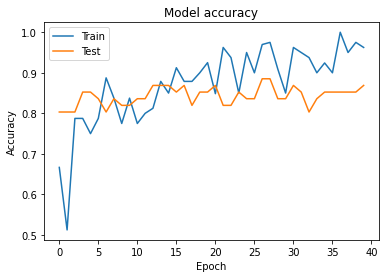

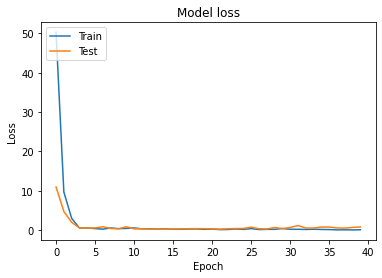

In [ ]:
# Accuracy
plt.plot(fit_result.history['accuracy'])
plt.plot(fit_result.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Loss
plt.plot(fit_result.history['loss'])
plt.plot(fit_result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

###Pruebas varias
Realizamos predicciones del modelo y estudiamos primeros resultados

In [ ]:
# Prediccion en las primeras 50 imagenes de test
predictions = arqmodel.predict(test_batches)

# Mostramos las predicciones de nuestro modelo.
print(np.argmax(predictions, axis=1))

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1]


Verificación Clasificación 3 Clases:

In [ ]:
# labels=['E','S','I'] 0,1,2
#imgtest = cv.imread('/content/datangc/Train/I/NGC0014_SDSS.jpg') # NO OK
#imgtest = cv.imread('/content/datangc/Train/I/UGC06181_SDSS.jpg') # OK 
#imgtest = cv.imread('/content/datangc/Train/S/CGCG536-030_SDSS.jpg') # OK
#imgtest = cv.imread('/content/datangc/Train/S/NGC0165_SDSS.jpg') # OK
#imgtest = cv.imread('/content/datangc/Train/S/NGC2604_SDSS.jpg') # OK
#imgtest = cv.imread('/content/datangc/Train/E/NGC0426_SDSS.jpg') 
imgtest = cv.imread('/content/datangc/Train/E/NGC2880_SDSS.jpg') 

img1 = np.expand_dims(imgtest, 0)
imgtest

In [ ]:
imgtest = cv.imread('/content/datangc/Train/I/NGC0014_SDSS.jpg') # NO OK
imgtest1 = cv.imread('/content/datangc/Train/I/UGC06181_SDSS.jpg') # OK 
imgtest2 = cv.imread('/content/datangc/Train/S/CGCG536-030_SDSS.jpg') # OK
imgtest3 = cv.imread('/content/datangc/Train/S/NGC0165_SDSS.jpg') # OK
imgtest4 = cv.imread('/content/datangc/Train/S/NGC2604_SDSS.jpg') # OK
imgtest5 = cv.imread('/content/datangc/Train/E/NGC0426_SDSS.jpg') 
imgtest6 = cv.imread('/content/datangc/Train/E/NGC2880_SDSS.jpg') 
imgtest7 = cv.imread('/content/datangc/Train/S/NGC1093_SDSS.jpg') 
imgtest8 = cv.imread('/content/datangc/Train/S/NGC2487_SDSS.jpg')
imgtest9 = cv.imread('/content/datangc/Train/S/NGC7311_SDSS.jpg') 
imgtest10 = cv.imread('/content/datangc/Train/S/NGC0160_SDSS.jpg')
imgtest11 = cv.imread('/content/datangc/Train/S/NGC7466_SDSS.jpg') 
imgtest12 = cv.imread('/content/datangc/Train/S/NGC2596_SDSS.jpg')


In [ ]:
imgtest = cv.imread('galax_0_3868.jpg')
imgtest1 = cv.imread('galax_0_3884.jpg')
imgtest2 = cv.imread('galax_0_333.jpg')
imgtest3 = cv.imread('galax_0_2050.jpg')

imgtest5 = cv.imread('galax_0_171.jpg')
imgtest6 = cv.imread('galax_0_563.jpg')
imgtest7 = cv.imread('galax_0_204.jpg')
imgtest8 = cv.imread('galax_0_989.jpg')




img1 = np.expand_dims(imgtest, 0)
img2 = np.expand_dims(imgtest1, 0)
img3 = np.expand_dims(imgtest2, 0)
img4 = np.expand_dims(imgtest3, 0)


In [ ]:
imgtest

In [ ]:
# Prediccion en las primeras 50 imagenes de test
predictions = arqmodel.predict(img1)

# Mostramos las predicciones de nuestro modelo.
print(np.argmax(predictions, axis=1))

[0]


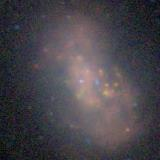

In [ ]:
Image.fromarray(imgtest)

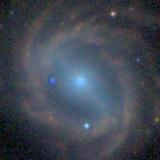

In [ ]:
Image.fromarray(imgtest8)

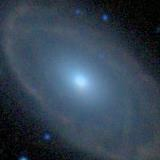

In [ ]:
Image.fromarray(imgtest10)

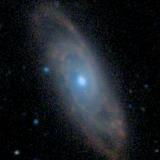

In [ ]:
Image.fromarray(imgtest11)

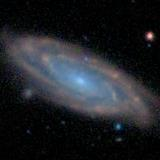

In [ ]:
Image.fromarray(imgtest12)

In [ ]:
layerdropout = Model(inputs=arqmodel.input, outputs=arqmodel.get_layer(arqmodel.output_names[0]).output)

In [ ]:
layerdropout.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
arqmodel.output_names[0]

'dense_1'

In [ ]:
img = np.expand_dims(imgtest,0)
uno = layerdropout.predict(img)

In [ ]:
uno

array([[2.8443334e-10, 1.0000000e+00, 9.9059802e-11]], dtype=float32)

In [ ]:
uno

array([[3.2992076e-10, 1.0000000e+00, 1.7338188e-13]], dtype=float32)

In [ ]:
img = np.expand_dims(imgtest1,0)
dos = layerdropout.predict(img)

In [ ]:
img = np.expand_dims(imgtest2,0)
tres = layerdropout.predict(img)

In [ ]:
img = np.expand_dims(imgtest3,0)
cuatro = layerdropout.predict(img)

In [ ]:
img = np.expand_dims(imgtest5,0)
cinco = layerdropout.predict(img)

In [ ]:
img = np.expand_dims(imgtest6,0)
seis = layerdropout.predict(img)

In [ ]:
img = np.expand_dims(imgtest7,0)
siete = layerdropout.predict(img)

In [ ]:
img = np.expand_dims(imgtest8,0)
ocho = layerdropout.predict(img)

In [ ]:
img = np.expand_dims(imgtest9,0)
nueve = layerdropout.predict(img)

In [ ]:
img = np.expand_dims(imgtest10,0)
diez = layerdropout.predict(img)

In [ ]:
img = np.expand_dims(imgtest11,0)
once = layerdropout.predict(img)

In [ ]:
img = np.expand_dims(imgtest12,0)
doce = layerdropout.predict(img)

In [ ]:
np.linalg.norm(tres-uno)

0.800856

In [ ]:
np.linalg.norm(nueve-dos)

1.4142135

In [ ]:
np.linalg.norm(tres-cuatro)

4.3865397e-10

In [ ]:
np.linalg.norm(once-ocho)

0.6113125

In [ ]:
np.linalg.norm(once-doce)

9.621677e-12

In [ ]:
np.linalg.norm(once-ocho)

0.6113125

In [ ]:
np.linalg.norm(nueve-ocho)

0.6113125

In [ ]:
np.linalg.norm(nueve-diez)

0.004380452

In [ ]:
np.linalg.norm(once-doce)

171.57529

In [ ]:
shutil.rmtree('/content/dataNGC/')

In [ ]:
os.listdir('/content/')

['.config',
 'datangc',
 'NGC3Class.zip',
 'arqmodel_CLASS3_1.h5py',
 'sample_data']

###A continuacion procedemos a cargar las imágenes que usaremos para establecer el ranking de similitud según la morfología de la Galaxia

In [12]:
# Subimos las imágenes con las que prepararemos nuestro dataset
uploaded = files.upload()

Saving NGCEspiralesVALIDATION.zip to NGCEspiralesVALIDATION.zip


In [13]:
!mkdir /content/datamorphology/

In [14]:
# Extraemos las imágenes del fichero que hemos subido
with ZipFile('NGCEspiralesVALIDATION.zip', 'r') as zipObj:
   zipObj.extractall('datamorphology')

In [175]:
#shutil.rmtree('/content/dataNGC/')
os.listdir('/content/datamorphology/Sbcnobarr')

['NGC5732_SDSS.jpg',
 'NGC5633_SDSS.jpg',
 'NGC2906_SDSS.jpg',
 'NGC6063_SDSS.jpg',
 'MCG-01-10-019_SDSS.jpg',
 'NGC5016_SDSS.jpg',
 'UGC04262_SDSS.jpg',
 'IC0208_SDSS.jpg',
 'UGC09476_SDSS.jpg',
 'NGC6301_SDSS.jpg',
 'MCG+10-17-007_SDSS.jpg',
 'UGC09708_SDSS.jpg',
 'NGC4047_SDSS.jpg',
 'NGC7489_SDSS.jpg',
 'UGC04461_SDSS.jpg',
 'NGC2916_SDSS.jpg',
 'NGC0477_SDSS.jpg',
 'NGC0001_SDSS.jpg',
 'NGC5980_SDSS.jpg',
 'UGC04375_SDSS.jpg',
 'NGC2596_SDSS.jpg',
 'UGC10803_SDSS.jpg',
 'NGC4711_SDSS.jpg',
 'NGC5145_SDSS.jpg',
 'NGC7466_SDSS.jpg',
 'UGC00005_SDSS.jpg',
 'NGC3994_SDSS.jpg',
 'NGC6132_SDSS.jpg',
 'UGC09598_SDSS.jpg',
 'IC1528_SDSS.jpg',
 'UGC02405_SDSS.jpg',
 'NGC3614_SDSS.jpg',
 'NGC5622_SDSS.jpg',
 'UGC09067_SDSS.jpg',
 'NGC5320_SDSS.jpg',
 'NGC3913_SDSS.jpg',
 'NGC7047_SDSS.jpg',
 'MCG-01-09-006_SDSS.jpg']

In [229]:
name = []
frame = []
#for (path, ficheros, archivos) in walk("/content/datamorphology/Sbcnobarr"):
#for (path, ficheros, archivos) in walk("/content/datamorphology/Sabnobarr"):
for (path, ficheros, archivos) in walk("/content/datamorphology/Sbcbarr"):
#    print(path)
#    print(ficheros)
    
 #   print(archivos)
    for file in archivos:
      newsize = (240,240)
      img = cv2.imread(os.path.join(path, file))
      img = cv2.resize(img,newsize)
      frame.append(img)
      name.append(os.path.join(path, file))

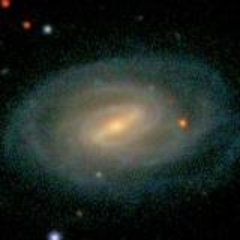

In [55]:
import cv2
img = cv2.imread('/content/datamorphology/Sbcbarr/NGC1093_SDSS.jpg')
img = cv2.resize(img,newsize)
cv2_imshow(img)

In [202]:
layerdropout = Model(inputs=arqmodel2.input, outputs=arqmodel2.get_layer(arqmodel2.output_names[0]).output)
#layerdropout = Model(inputs=arqmodel2.input, outputs=arqmodel2.get_layer('dropout_13').output)
layerdropout.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [230]:
results = []
for l in range(len(frame)):
  results.append(layerdropout.predict(np.expand_dims(frame[l],0)))

In [54]:
len(results)

40

In [231]:
for l in range(len(frame)):
  #print("Num: "+ str(l) + ' ' + str(name[l])[34:-4])
  #if (str(name[l])[34:-4] == 'NGC7466_SDSS'):
  #if (str(name[l])[34:-4] == 'NGC7311_SDSS'):
  if (str(name[l])[32:-4] == 'NGC6394_SDSS'):
  #if (str(name[l])[32:-4] == 'NGC0214_SDSS'):
  #if (str(name[l])[32:-4] == 'NGC1093_SDSS'):
  #if (str(name[l])[34:-4] == 'NGC2906_SDSS'):
    print("Num: "+ str(l) + ' ' + str(name[l])[32:-4])

Num: 30 NGC6394_SDSS


In [57]:
  dist = np.sqrt(np.sum((results[18]-results[2])**2))
  dist

1.1877426

In [232]:
import math
data = []
for i in range(len(results)):
  dist = np.sqrt(np.sum((results[24]-results[i])**2))
# NGC6394 NGC0214 NGC1093
  data = data + [[dist, str(name[i])[32:-4]]]
# NGC7311
  #data = data + [[dist, str(name[i])[34:-4]]]
# NGC7466
  #data = data + [[dist, str(name[i])[34:-4]]]
data.sort
print(data)


[[0.5470465, 'KUG1349+143_SDSS'], [0.56285757, 'UGC03944_SDSS'], [0.08003893, 'NGC1667_SDSS'], [0.3542035, 'NGC0551_SDSS'], [0.7572529, 'NGC7549_SDSS'], [0.27330738, 'NGC4185_SDSS'], [0.38253734, 'UGC12250_SDSS'], [0.11336301, 'NGC5947_SDSS'], [0.6904972, 'UGC03973_SDSS'], [0.70150536, 'UGC12810_SDSS'], [0.64087653, 'NGC7691_SDSS'], [0.4672991, 'NGC6032_SDSS'], [0.51071584, 'UGC05396_SDSS'], [0.40995303, 'KUG0210-078_SDSS'], [0.8460267, 'NGC3811_SDSS'], [0.25651884, 'UGC09842_SDSS'], [0.78810686, 'UGC02311_SDSS'], [0.49269006, 'NGC7591_SDSS'], [0.48481196, 'NGC1093_SDSS'], [0.8329016, 'NGC2347_SDSS'], [1.0298854, 'UGC11740_SDSS'], [0.7829655, 'NGC2543_SDSS'], [0.7246966, 'NGC2540_SDSS'], [0.8417648, 'NGC2780_SDSS'], [0.0, 'NGC6004_SDSS'], [0.24216689, 'NGC7321_SDSS'], [0.7063978, 'NGC5657_SDSS'], [0.45664912, 'NGC0976_SDSS'], [0.7742225, 'NGC5205_SDSS'], [0.5626269, 'NGC2253_SDSS'], [0.78798723, 'NGC6394_SDSS'], [0.7748718, 'UGC04132_SDSS'], [0.45331824, 'UGC07145_SDSS'], [0.7998505, '

In [233]:
# Import pandas library 
import pandas as pd 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Distance', 'Galaxy']) 
df = df.sort_values(by=['Distance'])

In [234]:
df.head(50)

,Distance,Galaxy
24,0.000000,NGC6004_SDSS
2,0.080039,NGC1667_SDSS
7,0.113363,NGC5947_SDSS
25,0.242167,NGC7321_SDSS
15,0.256519,UGC09842_SDSS
5,0.273307,NGC4185_SDSS
3,0.354203,NGC0551_SDSS
6,0.382537,UGC12250_SDSS
13,0.409953,KUG0210-078_SDSS
32,0.453318,UGC07145_SDSS


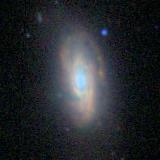

In [ ]:
Image.fromarray(frame[8])

In [236]:
df = df.head(6)

In [237]:
df

,Distance,Galaxy
24,0.000000,NGC6004_SDSS
2,0.080039,NGC1667_SDSS
7,0.113363,NGC5947_SDSS
25,0.242167,NGC7321_SDSS
15,0.256519,UGC09842_SDSS
5,0.273307,NGC4185_SDSS


In [240]:
img = []
imgname = []
for index, rows in df.iterrows():
  #print('/content/datamorphology/Sabnobarr/'+ df.loc[index, 'Galaxy'] + '.jpg')
  img.append(cv.imread('/content/datamorphology/Sbcbarr/'+ df.loc[index, 'Galaxy'] + '.jpg'))
  #img.append(cv.imread('/content/datamorphology/Sabnobarr/'+ df.loc[index, 'Galaxy'] + '.jpg'))
  #img.append(cv.imread('/content/datamorphology/Sbcnobarr/'+ df.loc[index, 'Galaxy'] + '.jpg'))
  imgname.append(df.loc[index, 'Galaxy'])

In [67]:
img.append(cv.imread('/content/datamorphology/Sbcbarr/NGC2253_SDSS.jpg'))
imgname.append('NGC0160_SDSS en posición 10')

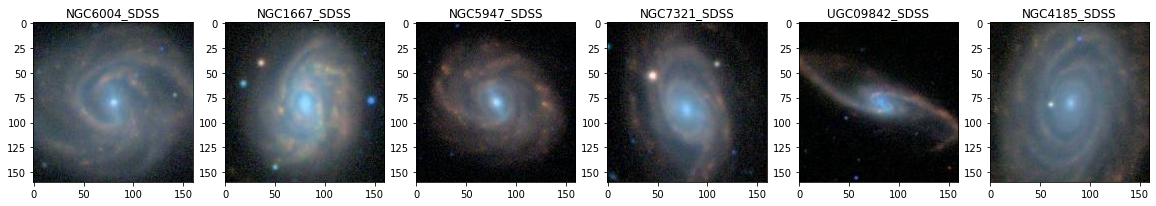

In [241]:
# Sacamos por pantalla las imágenes que hemos leído
plt.figure(figsize=(20, 30))
#plt.xticks([]),plt.yticks([])
fig = plt.figure(1)
l = (1,2,3,4,5,6)
for k in l:
  ax = fig.add_subplot(1,6,k)
  k = k -1
  ax.set_title(imgname[k])
  ax.imshow(img[k])      
plt.show()

### Observación capa a capa

In [ ]:
layer_outputs = [layer.output for layer in arqmodel2.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = Model(inputs=arqmodel2.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
img = np.expand_dims(np.array(cv_img[0]), 0)
activations = activation_model.predict(img)

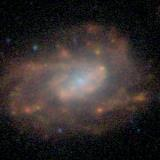

In [ ]:
imgpil = Image.fromarray(np.array(cv_img[0]))
imgpil

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 158, 158, 32)


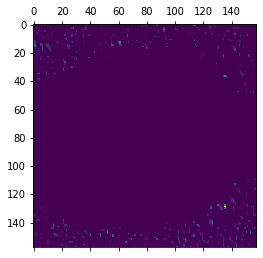

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

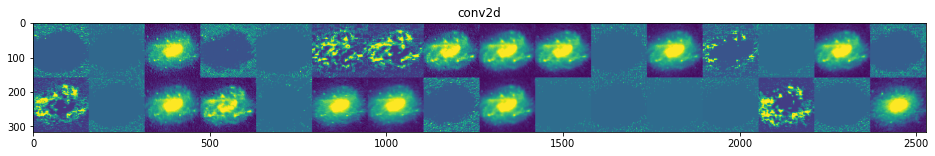

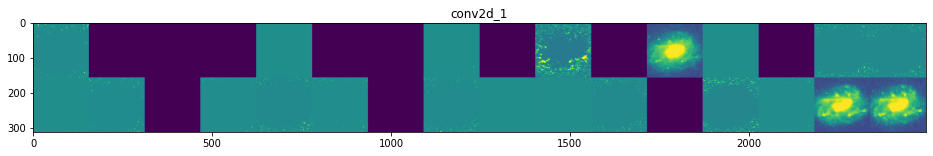

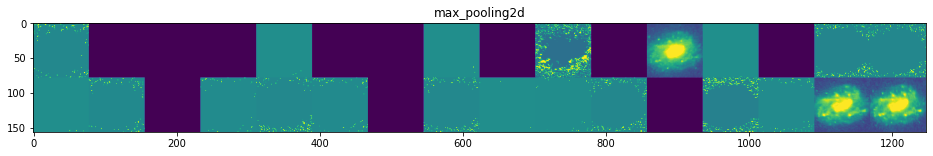

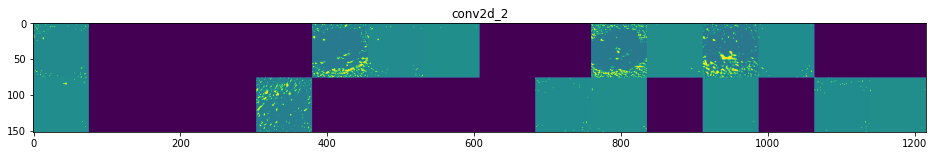

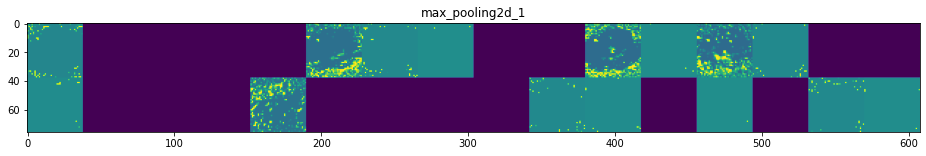

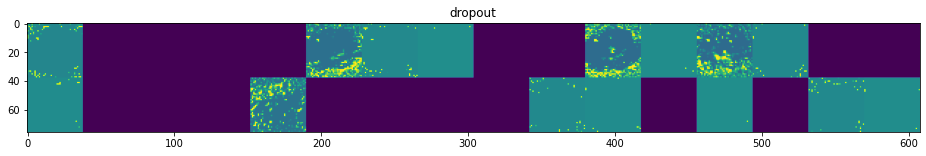

In [ ]:
layer_names = []
for layer in arqmodel2.layers[:6]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')